# Stock Replenishment using Stacked LSTM-RHN with Hyperparameter Tuning

**Objective:** The objective of this notebook is to predict the stock replenishment for a given product using the historical sales data. The model used in this notebook is a Stacked LSTM-RHN model. The model is trained on the historical sales data and is used to predict the stock replenishment for the next 30 days.    

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Input, Add, Flatten
from keras.callbacks import EarlyStopping
import keras_tuner as kt

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the sales data
df_sales = pd.read_excel('D:\\Python\\VYPER Inventory Replenishment\\raw_data\\gopro_sales_uk.xlsx')
df_sales

,Vyper ID,Shipping Label,Date,Dispatch Date,Customer Name,Shipping Address,Currency,Amount,Delivery Amount,Discount_amount,...,Payment Status,Invoice Status,Type,Marketplace,Online Order Id,Product Brand,Product Name,SKU,QTY,Serials
0,160816,GG434579491GB,2024-12-19T00:03:00Z,2024-12-19,Sharon Davis,"Josh Davis, 28 WEST ROAD, null, BURY ST. EDMUN...",GBP,79.16,0,0,...,Paid,PROCESSED,AMAZON_CO.UK,Vyper Global,204-3637982-5834702,GoPro,Ultra Wide Lens Mod,AEWAL-001,1,NaN
1,159928,OM393362997GB,2024-12-17,2024-12-18,Charlie Fowler,"Charlie Fowler, 9 Baliol Road, Newton Aycliffe...",GBP,208.33,0,0,...,Paid,PROCESSED,EBAY_GB,Go Pro,09-12474-83965,GoPro,HERO11 Black Mini,CHDHF-111-RW,1,NaN
2,159927,OM393362983GB,2024-12-17,2024-12-18,Ian Cale,"Ian Cale, No.3 Southsea Street, Manchester, GB...",GBP,274.99,0,0,...,Paid,PROCESSED,EBAY_GB,Go Pro,26-12455-84311,GoPro,GoPro HERO13 Black SWAG Bundle,CHDHX-131-RW-SWAG,1,NaN
3,159746,OM393362970GB,2024-12-17,2024-12-18,MONIKA RAZNIAK,"MONIKA RAZNIAK, 55 LANETHORPE CRESCENT, DARLIN...",GBP,24.16,0,0,...,Paid,PROCESSED,EBAY_GB,Go Pro,12-12470-68814,GoPro,Head Strap 2.0,ACHOM-002,1,NaN
4,159659,OM393362780GB,2024-12-17,2024-12-17,David J Hudson,"David J Hudson, 12 Russell Crescent, Trimdon S...",GBP,24.99,0,0,...,Paid,PROCESSED,EBAY_GB,Go Pro,12-12470-26165,GoPro,Enduro for HERO13 Black,AEBAT-001,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,149509,GG434562465GB,2024-10-26T13:02:05Z,2024-10-28,Soheil Torfakh,"Soheil, 14 GIBBS YARD 15, CROSS BEDFORD STREET...",GBP,35.82,0,0,...,Paid,PROCESSED,AMAZON_CO.UK,Vyper Global,026-3831446-3397929,GoPro,GoPro Casey,ABSSC-002,1,NaN
476,149508,GG434562451GB,2024-10-26T12:04:33Z,2024-10-28,Mason,"Mason Bamford, THE COTTAGE, BUTCHERS LANE PYTC...",GBP,27.49,0,0,...,Paid,PROCESSED,AMAZON_CO.UK,Vyper Global,202-3687229-5801159,GoPro,GoPro Chesty (Performance Chest Mount),AGCHM-001,1,NaN
477,149503,GG434562448GB,2024-10-26T11:13:10Z,2024-10-28,Fred banks,"Fred banks, 130, RUGBY ROAD, DAGENHAM, GB, GB,...",GBP,34.99,0,0,...,Paid,PROCESSED,AMAZON_CO.UK,Vyper Global,206-3805773-7805122,GoPro,Hand + Wrist Strap,AHWBM-002,1,NaN
478,149502,JY833553511GB,2024-10-26,2024-10-28,Robert Stanley,"Robert Stanley, 21 Rock Road, Solihull, West M...",GBP,20.83,0,0,...,Paid,PROCESSED,EBAY_GB,Go Pro,08-12242-97485,GoPro,GoPro Enduro Rechargeable Li-Ion Battery for H...,ADBAT-011,1,NaN


In [3]:
# Drop columns with all NaN values
df_sales.dropna(axis=1, how='all', inplace=True)
df_sales.head()

,Vyper ID,Shipping Label,Date,Dispatch Date,Customer Name,Shipping Address,Currency,Amount,Delivery Amount,Discount_amount,...,Full Total,Payment Status,Invoice Status,Type,Marketplace,Online Order Id,Product Brand,Product Name,SKU,QTY
0,160816,GG434579491GB,2024-12-19T00:03:00Z,2024-12-19,Sharon Davis,"Josh Davis, 28 WEST ROAD, null, BURY ST. EDMUN...",GBP,79.16,0,0,...,91.69,Paid,PROCESSED,AMAZON_CO.UK,Vyper Global,204-3637982-5834702,GoPro,Ultra Wide Lens Mod,AEWAL-001,1
1,159928,OM393362997GB,2024-12-17,2024-12-18,Charlie Fowler,"Charlie Fowler, 9 Baliol Road, Newton Aycliffe...",GBP,208.33,0,0,...,295.12,Paid,PROCESSED,EBAY_GB,Go Pro,09-12474-83965,GoPro,HERO11 Black Mini,CHDHF-111-RW,1
2,159927,OM393362983GB,2024-12-17,2024-12-18,Ian Cale,"Ian Cale, No.3 Southsea Street, Manchester, GB...",GBP,274.99,0,0,...,426.23,Paid,PROCESSED,EBAY_GB,Go Pro,26-12455-84311,GoPro,GoPro HERO13 Black SWAG Bundle,CHDHX-131-RW-SWAG,1
3,159746,OM393362970GB,2024-12-17,2024-12-18,MONIKA RAZNIAK,"MONIKA RAZNIAK, 55 LANETHORPE CRESCENT, DARLIN...",GBP,24.16,0,0,...,25.33,Paid,PROCESSED,EBAY_GB,Go Pro,12-12470-68814,GoPro,Head Strap 2.0,ACHOM-002,1
4,159659,OM393362780GB,2024-12-17,2024-12-17,David J Hudson,"David J Hudson, 12 Russell Crescent, Trimdon S...",GBP,24.99,0,0,...,26.24,Paid,PROCESSED,EBAY_GB,Go Pro,12-12470-26165,GoPro,Enduro for HERO13 Black,AEBAT-001,1


In [4]:
# Remove '12:35:57+00:00' from 'Date' column
df_sales['Date'] = pd.to_datetime(df_sales['Date'], format='%Y-%m-%d %H:%M:%S')
df_sales['Date'] = df_sales['Date'].astype(str)
df_sales['Date'] = df_sales['Date'].str.split(' ').str[0]
df_sales['Date'] = pd.to_datetime(df_sales['Date'])
df_sales.head()

,Vyper ID,Shipping Label,Date,Dispatch Date,Customer Name,Shipping Address,Currency,Amount,Delivery Amount,Discount_amount,...,Full Total,Payment Status,Invoice Status,Type,Marketplace,Online Order Id,Product Brand,Product Name,SKU,QTY
0,160816,GG434579491GB,2024-12-19,2024-12-19,Sharon Davis,"Josh Davis, 28 WEST ROAD, null, BURY ST. EDMUN...",GBP,79.16,0,0,...,91.69,Paid,PROCESSED,AMAZON_CO.UK,Vyper Global,204-3637982-5834702,GoPro,Ultra Wide Lens Mod,AEWAL-001,1
1,159928,OM393362997GB,2024-12-17,2024-12-18,Charlie Fowler,"Charlie Fowler, 9 Baliol Road, Newton Aycliffe...",GBP,208.33,0,0,...,295.12,Paid,PROCESSED,EBAY_GB,Go Pro,09-12474-83965,GoPro,HERO11 Black Mini,CHDHF-111-RW,1
2,159927,OM393362983GB,2024-12-17,2024-12-18,Ian Cale,"Ian Cale, No.3 Southsea Street, Manchester, GB...",GBP,274.99,0,0,...,426.23,Paid,PROCESSED,EBAY_GB,Go Pro,26-12455-84311,GoPro,GoPro HERO13 Black SWAG Bundle,CHDHX-131-RW-SWAG,1
3,159746,OM393362970GB,2024-12-17,2024-12-18,MONIKA RAZNIAK,"MONIKA RAZNIAK, 55 LANETHORPE CRESCENT, DARLIN...",GBP,24.16,0,0,...,25.33,Paid,PROCESSED,EBAY_GB,Go Pro,12-12470-68814,GoPro,Head Strap 2.0,ACHOM-002,1
4,159659,OM393362780GB,2024-12-17,2024-12-17,David J Hudson,"David J Hudson, 12 Russell Crescent, Trimdon S...",GBP,24.99,0,0,...,26.24,Paid,PROCESSED,EBAY_GB,Go Pro,12-12470-26165,GoPro,Enduro for HERO13 Black,AEBAT-001,1


In [5]:
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480 entries, 0 to 479
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Vyper ID          480 non-null    int64         
 1   Shipping Label    480 non-null    object        
 2   Date              480 non-null    datetime64[ns]
 3   Dispatch Date     480 non-null    object        
 4   Customer Name     480 non-null    object        
 5   Shipping Address  480 non-null    object        
 6   Currency          480 non-null    object        
 7   Amount            480 non-null    float64       
 8   Delivery Amount   480 non-null    int64         
 9   Discount_amount   480 non-null    int64         
 10  Tax amount        480 non-null    float64       
 11  Full Total        480 non-null    float64       
 12  Payment Status    480 non-null    object        
 13  Invoice Status    480 non-null    object        
 14  Type              480 non-

In [6]:
# Drop unnecessary columns
df_sales.drop(columns=['Vyper ID', 'Shipping Label', 'Dispatch Date', 'Currency', 'Delivery Amount', 
                       'Discount_amount','Payment Status', 'Invoice Status', 'Marketplace', 'Online Order Id','Product Brand'], inplace=True)
df_sales.head()

,Date,Customer Name,Shipping Address,Amount,Tax amount,Full Total,Type,Product Name,SKU,QTY
0,2024-12-19,Sharon Davis,"Josh Davis, 28 WEST ROAD, null, BURY ST. EDMUN...",79.16,12.53,91.69,AMAZON_CO.UK,Ultra Wide Lens Mod,AEWAL-001,1
1,2024-12-17,Charlie Fowler,"Charlie Fowler, 9 Baliol Road, Newton Aycliffe...",208.33,86.79,295.12,EBAY_GB,HERO11 Black Mini,CHDHF-111-RW,1
2,2024-12-17,Ian Cale,"Ian Cale, No.3 Southsea Street, Manchester, GB...",274.99,151.24,426.23,EBAY_GB,GoPro HERO13 Black SWAG Bundle,CHDHX-131-RW-SWAG,1
3,2024-12-17,MONIKA RAZNIAK,"MONIKA RAZNIAK, 55 LANETHORPE CRESCENT, DARLIN...",24.16,1.17,25.33,EBAY_GB,Head Strap 2.0,ACHOM-002,1
4,2024-12-17,David J Hudson,"David J Hudson, 12 Russell Crescent, Trimdon S...",24.99,1.25,26.24,EBAY_GB,Enduro for HERO13 Black,AEBAT-001,1


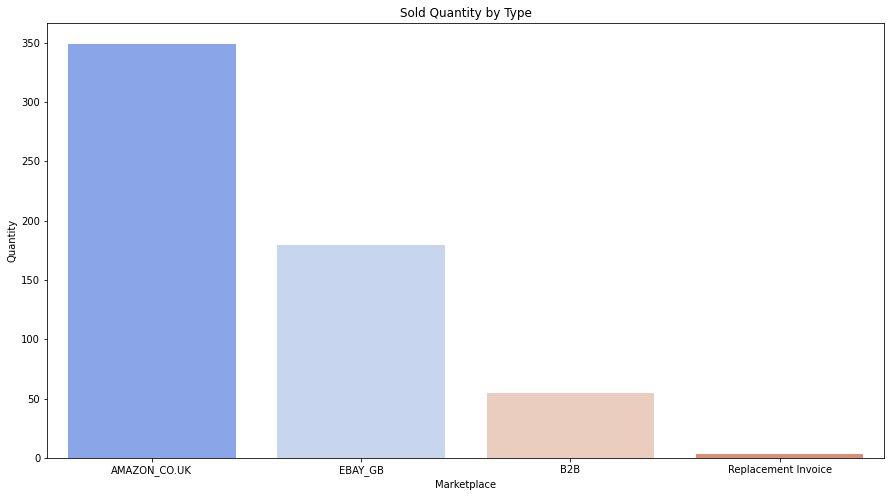

In [7]:
plt.figure(figsize=(15, 8))
sns.barplot(x='Type', y='QTY', data=df_sales, ci=None, estimator=sum, palette='coolwarm')
plt.title('Sold Quantity by Type')
plt.xlabel('Marketplace')
plt.ylabel('Quantity')
plt.show()

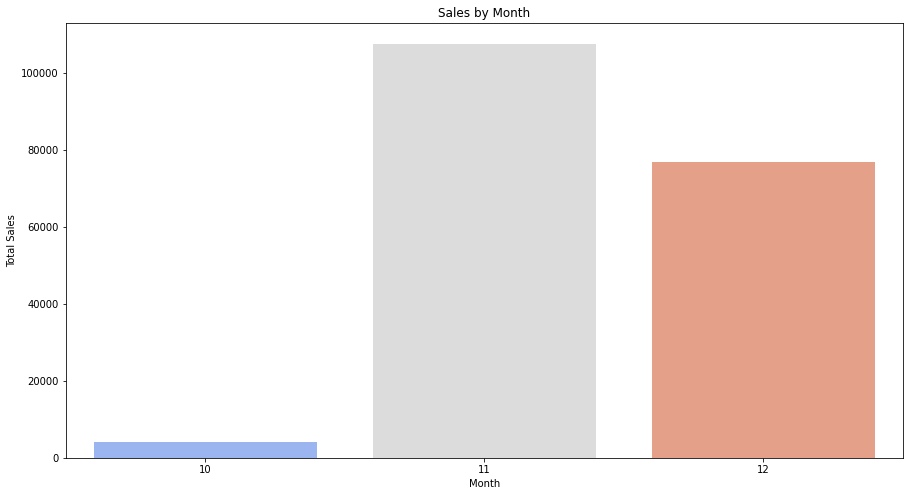

In [8]:
plt.figure(figsize=(15, 8))
sns.barplot(x=df_sales['Date'].dt.month, y='Full Total', data=df_sales, ci=None, estimator=sum, palette='coolwarm')
plt.title('Sales by Month')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.show()

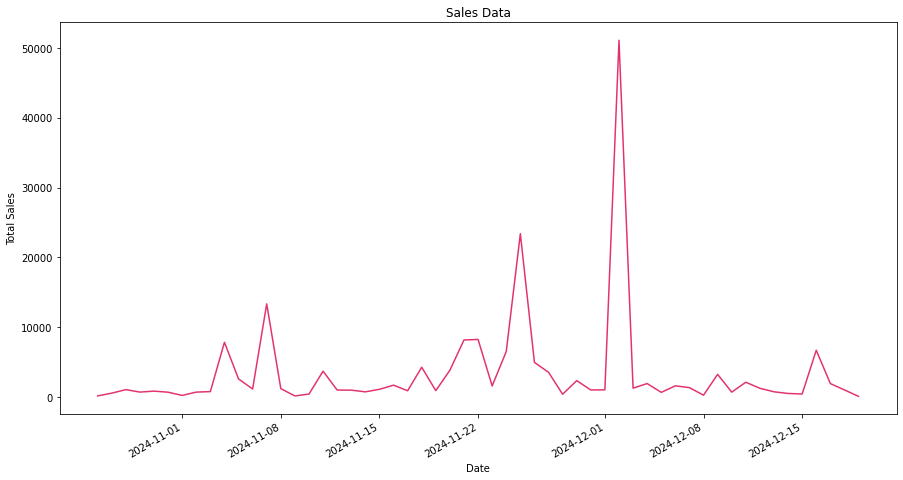

In [9]:
df_sales.groupby('Date')['Full Total'].sum().plot(kind='line', subplots=True, figsize=(15, 8), color='#e33270')
plt.title('Sales Data')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.show()

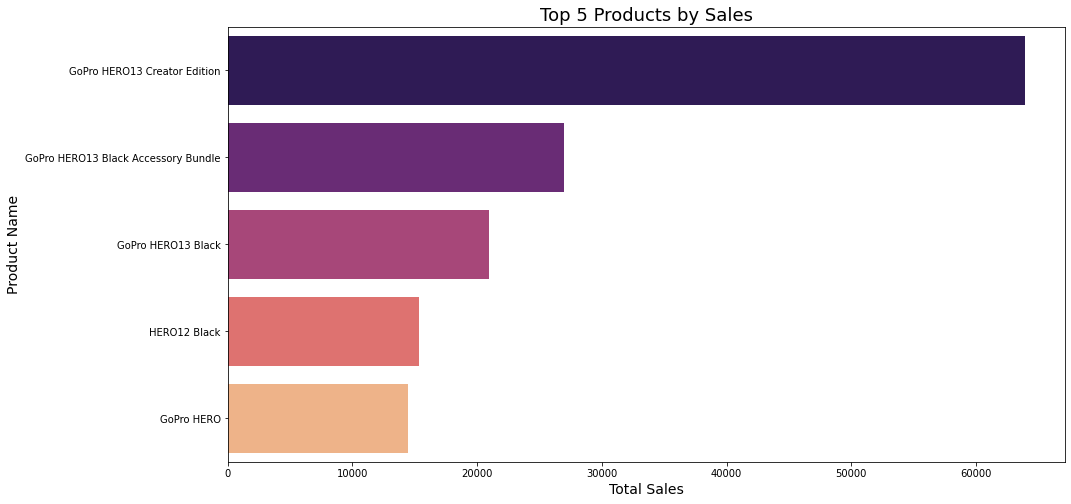

In [10]:
# Top 5 products by sales
fig, ax = plt.subplots(figsize=(15, 8))
top_5_sales = sns.barplot(data=df_sales.groupby('Product Name')['Full Total'].sum().sort_values(ascending=False).head(5).reset_index(), y='Product Name', x='Full Total', palette='magma')
plt.title('Top 5 Products by Sales', fontsize=18)
plt.xlabel('Total Sales', fontsize=14)
plt.ylabel('Product Name', fontsize=14)
plt.show()

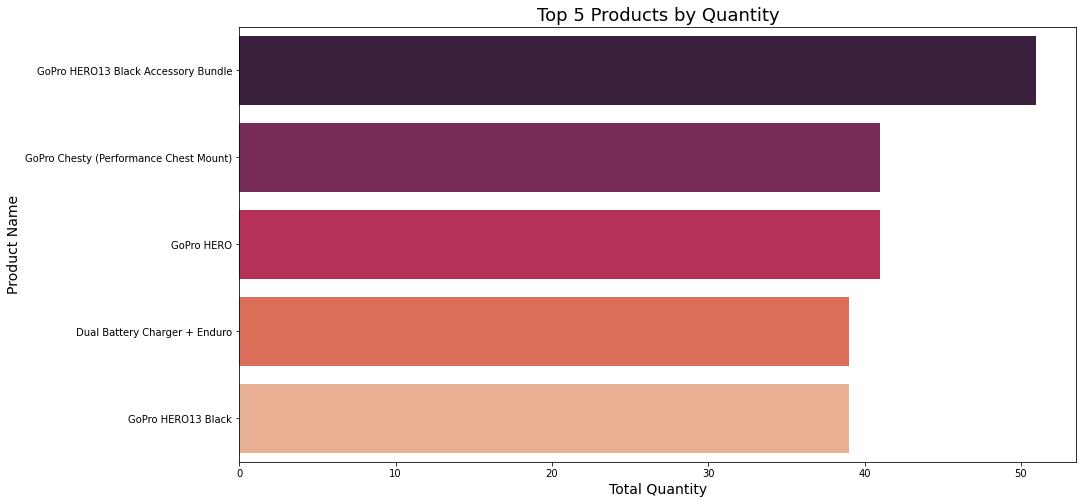

In [11]:
# Top 5 products by quantity
fig, ax = plt.subplots(figsize=(15, 8))
top_5_qty = sns.barplot(data=df_sales.groupby('Product Name')['QTY'].sum().sort_values(ascending=False).head(5).reset_index(), y='Product Name', x='QTY', palette='rocket')
plt.title('Top 5 Products by Quantity', fontsize=18)
plt.xlabel('Total Quantity', fontsize=14)
plt.ylabel('Product Name', fontsize=14)
plt.show()

In [12]:
# Load Stock Data
df_stock = pd.read_excel('D:\\Python\\VYPER Inventory Replenishment\\raw_data\\gopro_stock_uk.xlsx', skiprows=3)
df_stock.reset_index(drop=True, inplace=True)
df_stock.head()

,Stock Item,Brand Name,SKU,Initial Stock,Stock In,Stock Out,Stock On Hand,Manual Count,Variance,Cost,Total
0,GoPro HERO Session,GoPro,CHDNH-B13,0.0,0.0,0.0,0.0,NaN,NaN,40.28,0.00
1,GoPro HERO6 Black Refurb,GoPro,CHDNH-B17,0.0,0.0,0.0,0.0,NaN,NaN,0.00,0.00
2,GoPro HERO5 Session Refurb,GoPro,CHDNH-B16,-1.0,0.0,0.0,-1.0,NaN,NaN,69.75,-69.75
3,GoPro HERO5 Black Refurb,GoPro,CHDNH-B15,-2.0,0.0,0.0,-2.0,NaN,NaN,0.00,0.00
4,GoPro HERO4 Black Refurb,GoPro,CHDNH-B11,0.0,0.0,0.0,0.0,NaN,NaN,0.00,0.00


In [13]:
# Delete last row
df_stock.drop(df_stock.tail(1).index, inplace=True)
df_stock.tail()

,Stock Item,Brand Name,SKU,Initial Stock,Stock In,Stock Out,Stock On Hand,Manual Count,Variance,Cost,Total
311,HERO 8 Black - Non Packaged,GoPro,CHDHX-801-RW-NP,0.0,0.0,0.0,0.0,NaN,NaN,0.0000,0.0000
312,Flexible Grip Mount (Featuring Gear Ties),GoPro,AGRTM-002,6.0,0.0,0.0,6.0,NaN,NaN,17.0252,102.1512
313,GoPro SWAG - Frisbee/Towel/Box,GoPro,GP-SWAG-BDL-001,49.0,0.0,0.0,49.0,NaN,NaN,0.0000,0.0000
314,GoPro HERO13 Black SWAG Bundle,GoPro,CHDHX-131-RW-SWAG,0.0,0.0,0.0,0.0,NaN,NaN,0.0000,0.0000
315,HERO12 Black - Non Packaged,GoPro,CHDHX-121-RW-NP,0.0,0.0,0.0,0.0,NaN,NaN,0.0000,0.0000


In [14]:
# Drop columns with all NaN values
df_stock.dropna(axis=1, how='all', inplace=True)
df_stock.head()

,Stock Item,Brand Name,SKU,Initial Stock,Stock In,Stock Out,Stock On Hand,Cost,Total
0,GoPro HERO Session,GoPro,CHDNH-B13,0.0,0.0,0.0,0.0,40.28,0.00
1,GoPro HERO6 Black Refurb,GoPro,CHDNH-B17,0.0,0.0,0.0,0.0,0.00,0.00
2,GoPro HERO5 Session Refurb,GoPro,CHDNH-B16,-1.0,0.0,0.0,-1.0,69.75,-69.75
3,GoPro HERO5 Black Refurb,GoPro,CHDNH-B15,-2.0,0.0,0.0,-2.0,0.00,0.00
4,GoPro HERO4 Black Refurb,GoPro,CHDNH-B11,0.0,0.0,0.0,0.0,0.00,0.00


In [15]:
# Convert float64 columns to int64
df_stock = df_stock.astype({'Initial Stock': 'int64','Stock In': 'int64', 'Stock Out': 'int64', 'Stock On Hand': 'int64'})
df_stock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316 entries, 0 to 315
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Stock Item     316 non-null    object 
 1   Brand Name     316 non-null    object 
 2   SKU            316 non-null    object 
 3   Initial Stock  316 non-null    int64  
 4   Stock In       316 non-null    int64  
 5   Stock Out      316 non-null    int64  
 6   Stock On Hand  316 non-null    int64  
 7   Cost           316 non-null    float64
 8   Total          316 non-null    float64
dtypes: float64(2), int64(4), object(3)
memory usage: 22.3+ KB


In [16]:
# Drop unnecessary columns
#df_stock.drop(columns=['Brand Name', 'Initial Stock', 'Stock In', 'Stock Out', 'Manual Count', 'Variance'], inplace=True)
#df_stock.head()

In [17]:
# Aggregate sales data to daily level
daily_sales = df_sales.groupby('Date')['QTY'].sum().reset_index()

*  Adding rolling mean and rolling standard deviation features to the dataset.

In [18]:
# Calculate the rolling statistics
daily_sales['Rolling_Mean_7'] = daily_sales['QTY'].rolling(window=7).mean()
daily_sales['Rolling_Std_7'] = daily_sales['QTY'].rolling(window=7).std()

# Add lag features
daily_sales['Lag_1'] = daily_sales['QTY'].shift(1)
daily_sales['Lag_7'] = daily_sales['QTY'].shift(7)

daily_sales.fillna(0, inplace=True)

# Create additional time-based features
daily_sales['DayOfWeek'] = daily_sales['Date'].dt.dayofweek
daily_sales['Month'] = daily_sales['Date'].dt.month

daily_sales

,Date,QTY,Rolling_Mean_7,Rolling_Std_7,Lag_1,Lag_7,DayOfWeek,Month
0,2024-10-26,5,0.000000,0.000000,0.0,0.0,5,10
1,2024-10-27,6,0.000000,0.000000,5.0,0.0,6,10
2,2024-10-28,10,0.000000,0.000000,6.0,0.0,0,10
3,2024-10-29,7,0.000000,0.000000,10.0,0.0,1,10
4,2024-10-30,14,0.000000,0.000000,7.0,0.0,2,10
5,2024-10-31,11,0.000000,0.000000,14.0,0.0,3,10
6,2024-11-01,5,8.285714,3.450328,11.0,0.0,4,11
7,2024-11-02,7,8.571429,3.207135,5.0,5.0,5,11
8,2024-11-03,5,8.428571,3.359422,7.0,6.0,6,11
9,2024-11-04,16,9.285714,4.423961,5.0,10.0,0,11


Applying StandardScaler to the dataset.
- StandardScaler is used to standardize the features by removing the mean and scaling to unit variance.
- StandardScaler is applied to the features of the dataset.

In [19]:
# Normalize the data using StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(daily_sales[['QTY', 'Rolling_Mean_7', 'Rolling_Std_7', 'Lag_1', 'Lag_7', 'DayOfWeek', 'Month']])

Splitting the dataset into training and testing datasets.
   - The dataset is split into training and testing datasets.
   - The training dataset is used to train the model.
   - The testing dataset is used to evaluate the model.
   - The testing dataset is used to predict the stock replenishment for the next 30 days. 

In [20]:
# Prepare sequences for BiLSTM and Gradient Boosting models
sequence_length = 14
num_features = scaled_data.shape[1]

X, y = [], []
for i in range(len(scaled_data) - sequence_length):
    X.append(scaled_data[i:i+sequence_length])
    y.append(scaled_data[i+sequence_length, 0])

X, y = np.array(X), np.array(y)

In [21]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

Building a Stacked LSTM-RHN model.
   - The Stacked LSTM-RHN model is built using the Keras library.
   - The model is trained on the training dataset.
   - The model is used to predict the stock replenishment for the next 30 days.

In [22]:
# Build the LSTM model
def build_lstm_model(hp):
    model = Sequential()

    # Add LSTM layer
    model.add(LSTM(units=hp.Int('units', min_value=64, max_value=512, step=32),
                 input_shape=(sequence_length, num_features), return_sequences=False))
    model.add(Dropout(hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)))

    # Add Dense layer
    model.add(Dense(units=hp.Int('dense_units', min_value=64, max_value=512, step=32), activation='relu'))
    model.add(Dropout(hp.Float('dense_dropout', min_value=0.1, max_value=0.5, step=0.1)))

    # Output layer
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Initialize the tuner
tuner_lstm = kt.RandomSearch(
    build_lstm_model,
    objective='val_loss',
    max_trials=12,
    executions_per_trial=4,
    directory='lstm_tuner',
    project_name='lstm_model'
)

INFO:tensorflow:Reloading Tuner from lstm_tuner\lstm_model\tuner0.json


Now to get the best hyperparameters for the model, we will use the Hyperparameter Tuning technique. We will use the 'get_best_hyperparameters' function to get the best hyperparameters for the model. The function will return the best hyperparameters for the model.

In [23]:
# Search for the best hyperparameters
tuner_lstm.search(X_train, y_train, epochs=50, validation_split=0.2)

# Get the best hyperparameters and the model
best_hps_lstm = tuner_lstm.get_best_hyperparameters()[0]
lstm_model = tuner_lstm.hypermodel.build(best_hps_lstm)

# Train the final LSTM model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lstm_model.fit(X_train, y_train, epochs=100, validation_split=0.2, callbacks=[early_stopping], batch_size=32)

# Make predictions
lstm_test_pred = lstm_model.predict(X_test)

INFO:tensorflow:Oracle triggered exit
Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 1.4337 - val_loss: 0.3870
Epoch 2/100
1/1 [==============================] - 0s 57ms/step - loss: 1.2858 - val_loss: 0.3814
Epoch 3/100
1/1 [==============================] - 0s 49ms/step - loss: 1.2221 - val_loss: 0.3737
Epoch 4/100
1/1 [==============================] - 0s 45ms/step - loss: 1.2217 - val_loss: 0.3760
Epoch 5/100
1/1 [==============================] - 0s 47ms/step - loss: 1.0963 - val_loss: 0.3842
Epoch 6/100
1/1 [==============================] - 0s 46ms/step - loss: 1.1496 - val_loss: 0.4029
Epoch 7/100
1/1 [==============================] - 0s 45ms/step - loss: 1.0420 - val_loss: 0.4305
Epoch 8/100
1/1 [==============================] - 0s 48ms/step - loss: 1.0264 - val_loss: 0.4736
Epoch 9/100
1/1 [==============================] - 0s 50ms/step - loss: 0.9638 - val_loss: 0.5479
Epoch 10/100
1/1 [==============================] - 0s 57ms/step - loss: 0.9641 - 

Similar to what we did for LSTM model, let's build RHN model and then stack them to get the Stacked LSTM-RHN model.

In [24]:
# Build RHN model
def build_rhn_model(hp):
    inputs = Input(shape=(sequence_length, num_features))
    x = inputs

    # Recurrent Highway Network approximation using multiple LSTM layers
    for _ in range(hp.Int('num_layers', 1, 3)):
        x_residual = Dense(hp.Int('units', min_value=64, max_value=512, step=32))(x)  # Adjusting the shape of x_residual
        x = LSTM(units=hp.Int('units', min_value=64, max_value=512, step=32), return_sequences=True)(x)
        x = Add()([x, x_residual])  # Residual connection

    x = Flatten()(x)
    x = Dropout(hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1))(x)
    outputs = Dense(1)(x)

    model = keras.models.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Initialize the tuner
tuner_rhn = kt.RandomSearch(
    build_rhn_model,
    objective='val_loss',
    max_trials=12,
    executions_per_trial=4,
    directory='rhn_tuner',
    project_name='rhn_model'
)

INFO:tensorflow:Reloading Tuner from rhn_tuner\rhn_model\tuner0.json


In [25]:
# Search for the best hyperparameters
tuner_rhn.search(X_train, y_train, epochs=50, validation_split=0.2)

# Get the best hyperparameters and the model
best_hps_rhn = tuner_rhn.get_best_hyperparameters()[0]
rhn_model = tuner_rhn.hypermodel.build(best_hps_rhn)

# Train the final RHN model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
rhn_model.fit(X_train, y_train, epochs=100, validation_split=0.2, callbacks=[early_stopping], batch_size=32)

# Make predictions
rhn_test_pred = rhn_model.predict(X_test)

INFO:tensorflow:Oracle triggered exit
Epoch 1/100
1/1 [==============================] - 7s 7s/step - loss: 1.6876 - val_loss: 18.3269
Epoch 2/100
1/1 [==============================] - 0s 304ms/step - loss: 2.9981 - val_loss: 7.2745
Epoch 3/100
1/1 [==============================] - 0s 290ms/step - loss: 0.7372 - val_loss: 2.3039
Epoch 4/100
1/1 [==============================] - 0s 304ms/step - loss: 0.7472 - val_loss: 2.0191
Epoch 5/100
1/1 [==============================] - 0s 302ms/step - loss: 0.6579 - val_loss: 2.7253
Epoch 6/100
1/1 [==============================] - 0s 303ms/step - loss: 0.6119 - val_loss: 3.9818
Epoch 7/100
1/1 [==============================] - 0s 288ms/step - loss: 0.5484 - val_loss: 5.2583
Epoch 8/100
1/1 [==============================] - 0s 275ms/step - loss: 0.4498 - val_loss: 6.0411
Epoch 9/100
1/1 [==============================] - 0s 275ms/step - loss: 0.2794 - val_loss: 6.0846
Epoch 10/100
1/1 [==============================] - 0s 261ms/step - loss:

In [26]:
# Combine the predictions using column stacking
stacked_predictons = np.column_stack((lstm_test_pred.flatten(), rhn_test_pred.flatten()))

# Train a final regressor on the stacked predictions
final_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
final_regressor.fit(stacked_predictons, y_test)

# Make predictions
final_pred = final_regressor.predict(stacked_predictons)

# Inverse transform the predictions
final_pred_rescaled = scaler.inverse_transform(np.column_stack([final_pred.reshape(-1, 1),
                                                                np.zeros((final_pred.shape[0], num_features - 1))]))[:, 0]

In [27]:
# Calculate the evaluation metrics
mae = mean_absolute_error(scaler.inverse_transform(np.column_stack([y_test.reshape(-1, 1),
                                np.zeros((y_test.shape[0], num_features - 1))]))[:, 0], final_pred_rescaled)
mse = mean_squared_error(scaler.inverse_transform(np.column_stack([y_test.reshape(-1, 1),
                                np.zeros((y_test.shape[0], num_features - 1))]))[:, 0], final_pred_rescaled)
r2 = r2_score(scaler.inverse_transform(np.column_stack([y_test.reshape(-1, 1),
                                np.zeros((y_test.shape[0], num_features - 1))]))[:, 0], final_pred_rescaled)
rmse = np.sqrt(mse)

print(f'Mean Absolute Error: {mae:.2f}')
print(f'Mean Squared Error: {mse:.2f}')
print(f'R2 Score: {r2:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')

Mean Absolute Error: 1.26
Mean Squared Error: 3.18
R2 Score: 0.80
Root Mean Squared Error: 1.78


In [28]:
# Forecast next 30 days
future_predictions = []
last_sequence = scaled_data[-sequence_length:]

for _ in range(30):
    # Predict the next value using LSTM and RHN
    lstm_next_pred = lstm_model.predict(last_sequence.reshape(1, sequence_length, num_features))
    rhn_next_pred = rhn_model.predict(last_sequence.reshape(1, sequence_length, num_features))

    # Combine the predictions using column stacking
    stacked_next_pred = np.column_stack((lstm_next_pred.flatten(), rhn_next_pred.flatten()))
    final_next_pred = final_regressor.predict(stacked_next_pred)

    # Store the final prediction
    future_predictions.append(final_next_pred)

    # Update the sequence
    next_input = np.concatenate([last_sequence[-1, :-1], final_next_pred])
    last_sequence = np.vstack([last_sequence[1:], next_input])

# Convert the future predictions to a single array
future_predictions = np.array(future_predictions).reshape(-1, 1)

# Concatenate zeros to match the original feature shape for Inverse Transformation
future_predictions_full = np.column_stack([future_predictions, np.zeros((future_predictions.shape[0], num_features - 1))])

# Inverse transform the predictions
future_predictions_rescaled = scaler.inverse_transform(future_predictions_full)
future_predictions_units = future_predictions_rescaled[:, 0]

1/1 [==============================] - 0s 32ms/step


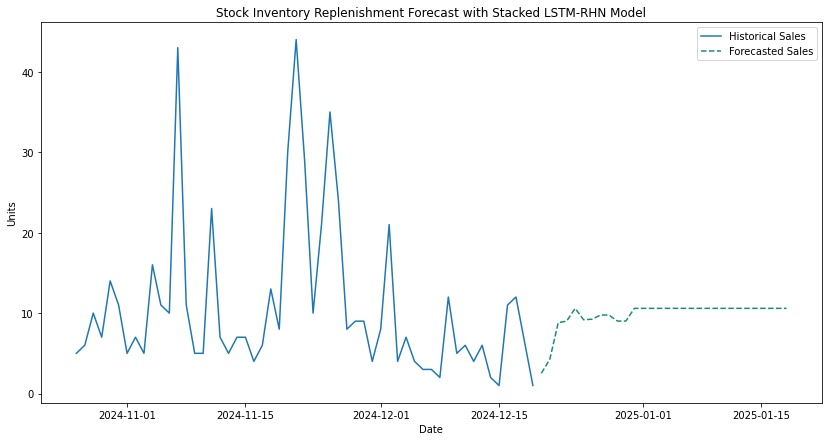

In [29]:
# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(daily_sales['Date'], daily_sales['QTY'], label='Historical Sales')
future_dates = pd.date_range(start=daily_sales['Date'].max() + pd.Timedelta(days=1), periods=30)
plt.plot(future_dates, future_predictions_units, label='Forecasted Sales', linestyle='--', color='#168e72')
plt.xlabel('Date')
plt.ylabel('Units')
plt.title('Stock Inventory Replenishment Forecast with Stacked LSTM-RHN Model')
plt.legend()
plt.show()

In [30]:
# Calculate the actual units sold for each SKU in the last 30 days
last_30_days_sales = df_sales[df_sales['Date'] > df_sales['Date'].max() - pd.Timedelta(days=30)]
last_30_days_sales = last_30_days_sales.groupby(['SKU', 'Product Name'])['QTY'].sum().reset_index()
last_30_days_sales.columns = ['SKU', 'Product Name','Last_30_Days_Sales']

# Get the current stock levels for each SKU
current_stock_levels = df_stock.groupby('SKU')['Stock On Hand'].sum().reset_index()
current_stock_levels.columns = ['SKU', 'Current_Stock']

# Merge the last 30 days sales and current stock levels
restock_skus = pd.merge(last_30_days_sales, current_stock_levels, on='SKU')

# Calculate the forecasted demand for the next 30 days based on the model's forecast
average_daily_forecast = future_predictions_units.mean()

# Determine the restock quantity
# The restock quantity should cover the forecasted demand minus the current stock levels
# If the forecasted demand is less than the current stock levels, no restock is needed
# If last 30 days sales are lower than the forecasted demand, the restock quantity is based on the forecasted demand
restock_skus['Restock_Quantity'] = restock_skus.apply(lambda x: max(0, average_daily_forecast - x['Current_Stock']), axis=1)

# Restock quantity not required for SKUs start with 'UKRFB
restock_skus = restock_skus[~restock_skus['SKU'].str.startswith('UKRFB')]

# Restock quantity not required for SKUs ends with '- R'
restock_skus = restock_skus[~restock_skus['SKU'].str.endswith('- R')].reset_index(drop=True)

# Set Restock Quantity to whole integer values
restock_skus['Restock_Quantity'] = restock_skus['Restock_Quantity'].apply(np.ceil).astype(int)

# Restock quantity for each SKU should be multiples of 6. Ex:- 6, 12, 18, 24, etc.
restock_skus['Restock_Quantity'] = restock_skus['Restock_Quantity'].apply(lambda x: x + (6 - x) % 6)

# Display the SKUs that need restocking along with the quantity
print("SKUs that need restocking with required quantities:")
display(restock_skus[['SKU', 'Product Name', 'Last_30_Days_Sales', 'Current_Stock','Restock_Quantity']])

SKUs that need restocking with required quantities:


,SKU,Product Name,Last_30_Days_Sales,Current_Stock,Restock_Quantity
0,AACFT-001,GoPro Curved + Flat Adhesive Mounts,6,4,6
1,ABSSC-002,GoPro Casey,25,1,12
2,ACBAT-011,MAX Enduro Battery,3,12,0
3,ACDBD-011-EU,MAX Dual Battery Charger + Enduro Battery,10,4,6
4,ACHOM-002,Head Strap 2.0,8,2,12
5,ACMPM-001,GoPro Jaws: Flex Clamp,7,10,0
6,ADBAT-011,GoPro Enduro Rechargeable Li-Ion Battery for H...,12,2,12
7,ADCOD-001,USB Pass-Through Door (HERO9 Black),9,5,6
8,ADFMD-001,Media Mod (HERO9 Black),12,2,12
9,ADWAL-001,HERO9 BLACK Max Lens Mod,7,2,12


In [31]:
average_daily_forecast

9.744999999999997

In [33]:
# Highlight the SKUs that need restocking above a certain threshold with a color
def highlight_restock(x):
    color = 'background-color: #1259a1' if x['Current_Stock'] <= 10 else ''
    return [color for _ in x]

restock_skus.style.apply(highlight_restock, axis=1)

,SKU,Product Name,Last_30_Days_Sales,Current_Stock,Restock_Quantity
0,AACFT-001,GoPro Curved + Flat Adhesive Mounts,6,4,6
1,ABSSC-002,GoPro Casey,25,1,12
2,ACBAT-011,MAX Enduro Battery,3,12,0
3,ACDBD-011-EU,MAX Dual Battery Charger + Enduro Battery,10,4,6
4,ACHOM-002,Head Strap 2.0,8,2,12
5,ACMPM-001,GoPro Jaws: Flex Clamp,7,10,0
6,ADBAT-011,GoPro Enduro Rechargeable Li-Ion Battery for HERO9/10 Black,12,2,12
7,ADCOD-001,USB Pass-Through Door (HERO9 Black),9,5,6
8,ADFMD-001,Media Mod (HERO9 Black),12,2,12
9,ADWAL-001,HERO9 BLACK Max Lens Mod,7,2,12
